In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats
import scipy.signal
import seaborn as sns

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import TableHDU, BinTableHDU

from mcar.estimate import *
from mcar.simulate import *

In [15]:
data_dir = './astro/data'
plots_dir = './astro/figs'

## Fit CAR($p$) models to active galactic nuclei (AGN) light curves
The first optical light curve is from the Kepler observatory for the local AGN Zw 229-15 in quarter Q9.

In [ ]:
# set memmap=True for large files 
# Q9 is 'data\kplr006932990-2011177032512_llc.fits'
with fits.open(os.path.join(data_dir, 'kplr006932990-2011177032512_llc.fits'), memmap=True) as hdu_list:
    arr = np.array(hdu_list[1].data)

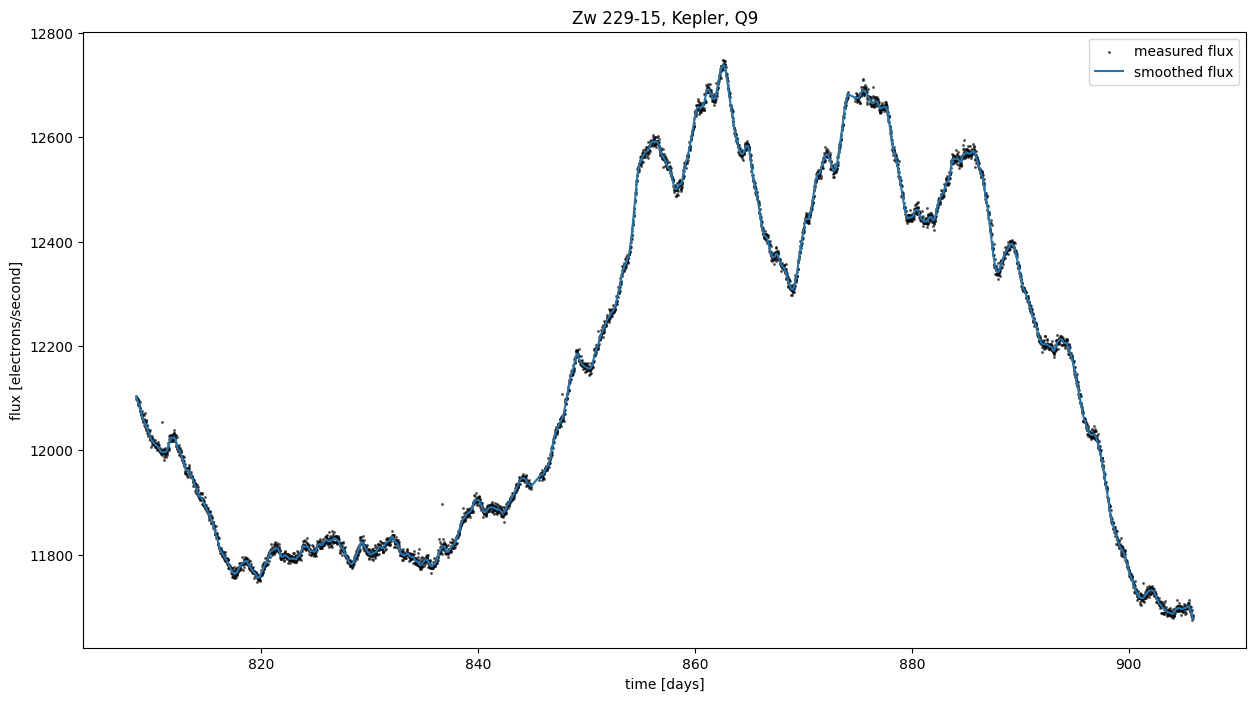

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(arr['TIME'], arr['SAP_FLUX'], s=1.5, alpha=0.5, label='measured flux', color='black')
indices = ~np.isnan(arr['TIME']) & ~np.isnan(arr['SAP_FLUX'])
raw_data = arr['SAP_FLUX'][indices].astype(float)
time_grid = arr['TIME'][indices].astype(float)
smoothed_data = sm.nonparametric.lowess(endog=raw_data, exog=time_grid, frac=0.005, return_sorted=False)
plt.plot(time_grid, smoothed_data, color='tab:blue', label='smoothed flux')
plt.title('Zw 229-15, Kepler, Q9')
plt.xlabel('time [days]')
plt.ylabel('flux [electrons/second]')
# plt.scatter(arr['TIME'], arr['PDCSAP_FLUX'])
plt.legend()
plt.show()
fig.savefig(os.path.join(plots_dir, 'Zw_229-15_Kepler_Q9.eps'))

In [ ]:
observation = smoothed_data.reshape(1, -1)

# note that our results suggest we should be using the same Q across p's, also to obtain a more "coherent" likelihood and AIC (same approximations)
Q_subset_factor = 6

Q_subset = np.arange(0, len(time_grid), Q_subset_factor)

Q = time_grid[Q_subset]
P = time_grid[:(Q_subset[-1]+1)]
Y = observation[:, :len(P)]

ps = list(range(1, 8))
AICs = []

for p in ps:
    AA_hat, (b_hat, Sigma_hat) = estimate_MCAR(Y=Y, p=p, P=P, Q=Q, max_iter=500)
    loglikelihood = loglikelihood_MCAR(Y=Y, p=p, P=P, Q=Q, AA=AA_hat, b=b_hat, Sigma=Sigma_hat)
    AICs.append(2*(p + 1 + 1) - 2 * loglikelihood)

c:\Users\ll1917\PhD\MCAR\code\mcar\mcar\estimate.py:430: UserWarning: maximum number of iterations exceeded.
  warnings.warn('maximum number of iterations exceeded.')


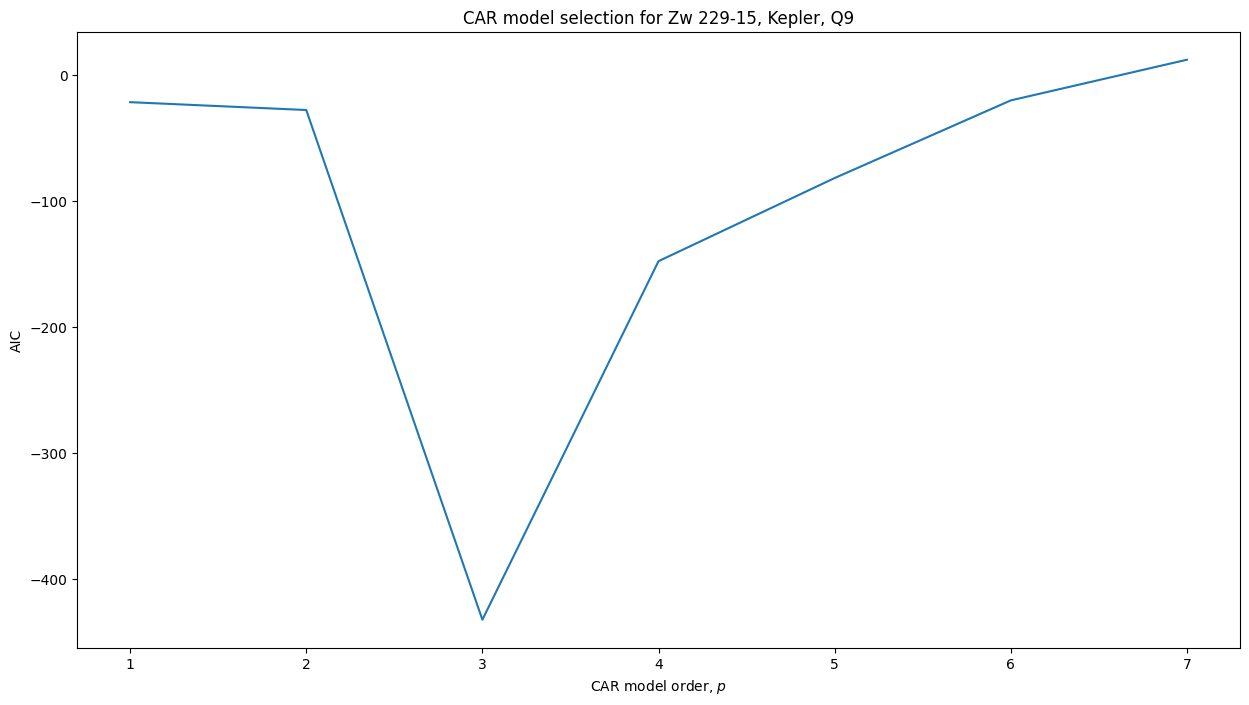

In [ ]:
fig = plt.figure(figsize=(15, 8))
plt.title('CAR model selection for Zw 229-15, Kepler, Q9')
plt.xlabel('CAR model order, $p$')
plt.ylabel('AIC')
plt.plot(ps, AICs)
plt.show()
fig.savefig(os.path.join(plots_dir, 'figs/AIC.eps'))

In [ ]:
p = 2

AA_hat, (b_hat, Sigma_hat) = estimate_MCAR(Y=Y, p=p, P=P, Q=Q, max_iter=100)

In [ ]:
H, HH = compute_H_HH(Y=Y, p=p, P=P, Q=Q, b=b_hat, nu=None, Sigma_inv = np.linalg.inv(Sigma_hat))
AA_hat_cov = np.linalg.inv(HH)

In [10]:
for i, (AA_hat_i, AA_hat_cov_i) in enumerate(zip(AA_hat, np.diag(AA_hat_cov))):
    print(f'A_{i+1} = {AA_hat_i[0, 0]:.5f} +/- {2*np.sqrt(AA_hat_cov_i):.5f}')
print(f'b_hat = {b_hat[0]:.5f}')
print(f'Sigma_hat = {Sigma_hat[0, 0]:.5f}')

A_1 = 0.67009 +/- 0.22528
A_2 = 0.00038 +/- 0.00118
b_hat = 4.67399
Sigma_hat = 4963.22546


Note, to estimate jump-related quantities we use the approach in Gegler 2011 assuming the jump measure $F$ is finite.

In [ ]:
DeltaL = recover_BDLP(Y, p, P, Q, AA_hat)
jump_rate = estimate_integral_Levy_measure(DeltaL, Q, Sigma_hat, K = lambda x: True, f = lambda x: 1.)
jump_mean = estimate_integral_Levy_measure(DeltaL, Q, Sigma_hat, K = lambda x: True, f = lambda x: x)[0] / jump_rate if jump_rate > 0 else 0
jump_scale = np.sqrt(estimate_integral_Levy_measure(DeltaL, Q, Sigma_hat, K = lambda x: True, f = lambda x: np.outer(x, x))[0,0] / jump_rate) if jump_rate > 0 else 0

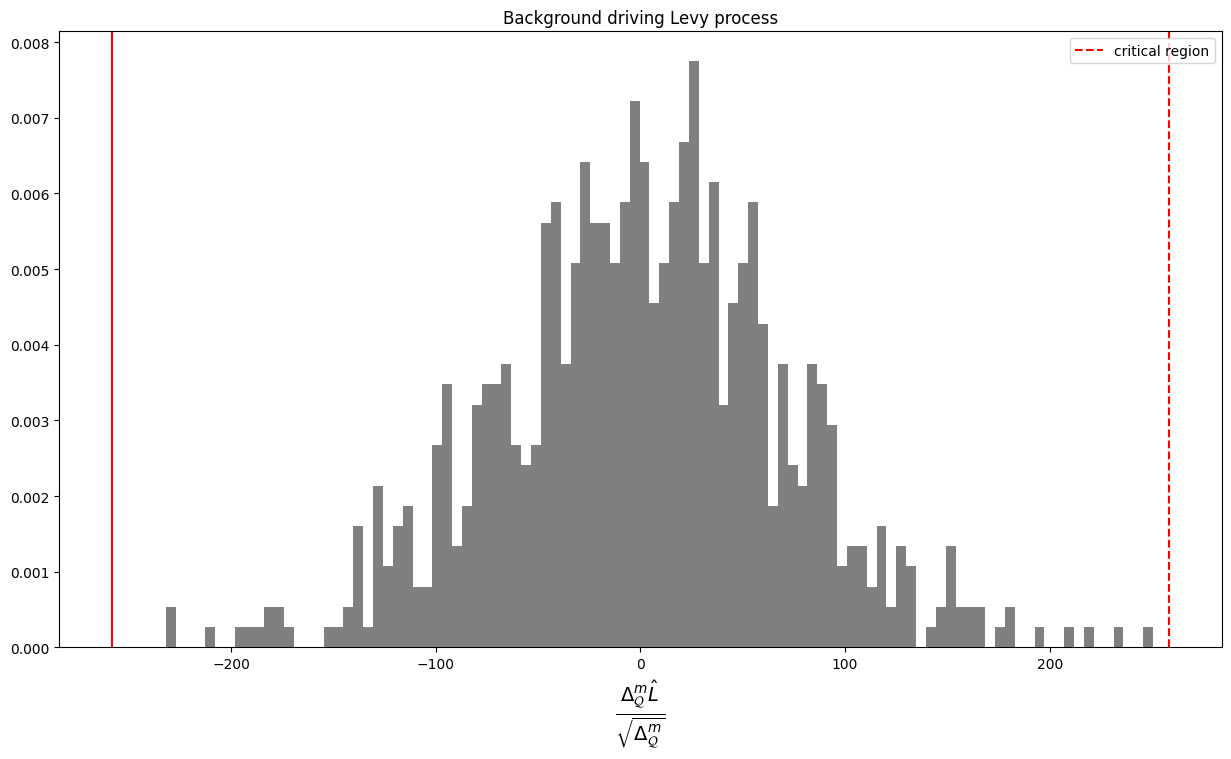

<Figure size 640x480 with 0 Axes>

In [83]:
fig = plt.figure(figsize=(15, 8))
plt.hist(DeltaL[0, :] / np.sqrt(np.diff(Q)), color='black', bins=100, alpha=0.5, density=True)
np.random.seed(123)
# plt.hist(scipy.stats.norm(loc=0, scale=np.sqrt(Sigma_hat)).rvs(len(Q)), color='red', alpha=0.5, bins=100)
plt.axvline(np.sqrt(2.02*Sigma_hat*np.log(len(Q))), color='red', label='critical region', linestyle='--')
plt.axvline(-np.sqrt(2.02*Sigma_hat*np.log(len(Q))), color='red')
plt.title('Background driving Levy process')
plt.xlabel(r'$\frac{\Delta^m_{\mathcal{Q}} \hat{L}}{\sqrt{\Delta^m_{\mathcal{Q}}}}$', fontsize=20)
plt.legend()
plt.show()
plt.savefig(os.path.join(plots_dir, 'Levy_process.eps'))

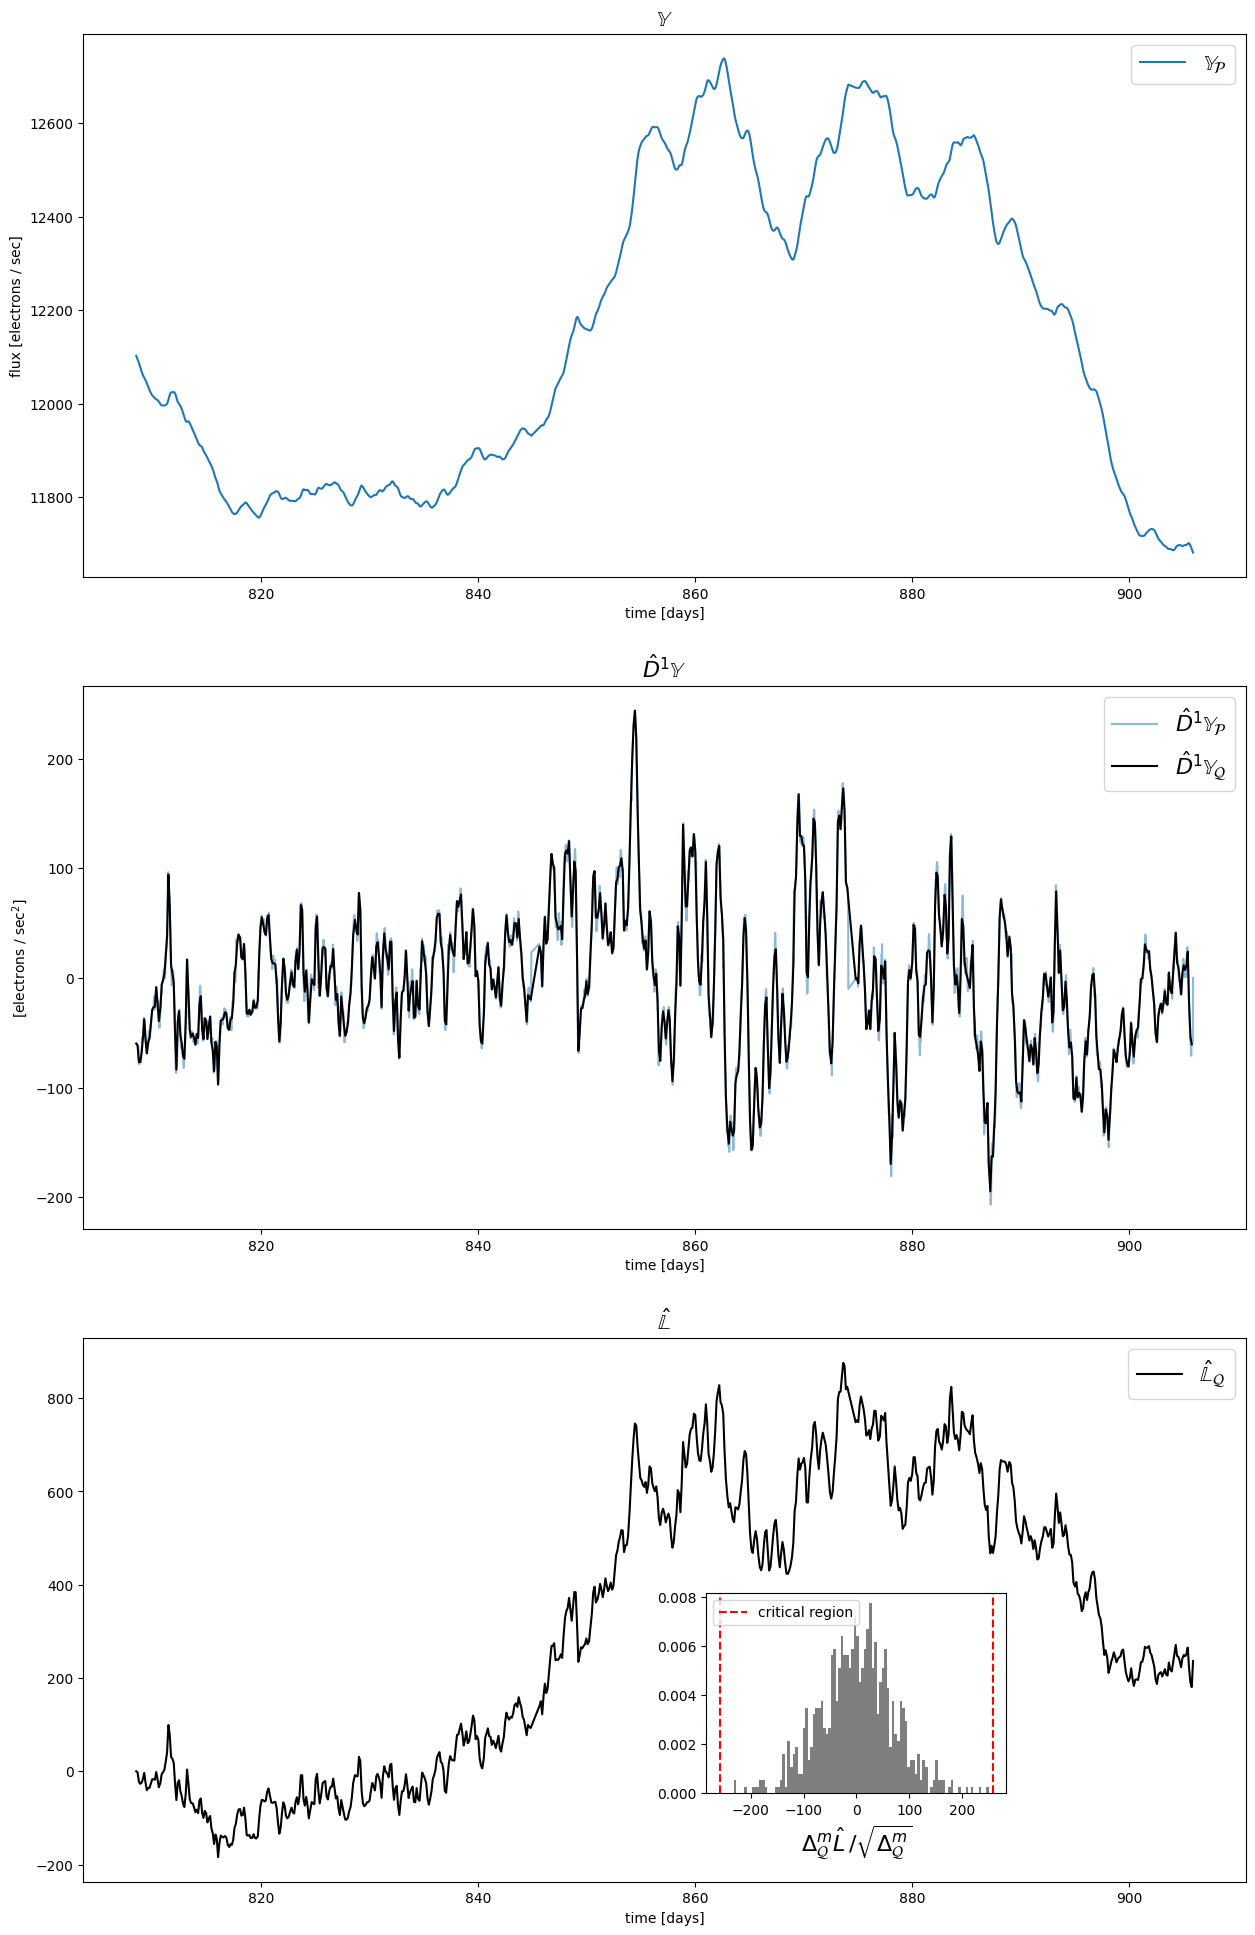

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [84]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

X = state_space(Y, p, P)

# find indices of Q in P
indices = [False] * len(P)
Q_to_P = [0] * len(Q)
k = 0
for i, s in enumerate(P):
    if s == Q[k]:
        indices[i] = True
        Q_to_P[k] = i
        k += 1
Q_to_P.append(len(P))

X_Q = X[:, indices]

colors = ['black', 'red'] 

fig, axes = plt.subplots(p+1, 1, figsize=(15, (p+1)*8))
if p == 1:
    axes = [axes]
for j in range(p):
    axes[j].plot(P, X[j, :], label=f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}_{{\mathcal{{P}}}}$' if j > 0 else '$\mathbb{Y}_{\mathcal{P}}$', alpha = 1 if j == 0 else 0.5)
    if j > 0:        
        if j < p-1:
            axes[j].plot(Q, X_Q[j, :], label=f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$', color=colors[0])
        elif j == p-1:
            # get P_0-continuous martingale part of p-1-th derivative of MCAR realisation
            DY = np.diff(X_Q[j, :] - X_Q[j, 0] - b_hat * Q)

            # choose nu from data
            nu = choose_nu(DY.reshape(1, -1), Q).flatten()

            assert len(DY) == len(nu)
            
            start = 0
            for m in range(len(DY)):
                if np.abs(DY[m]) > nu[m]:
                    # sns.lineplot(ax=axes[j], x=P[Q_to_P[start]:Q_to_P[m+1]], y=X[j, Q_to_P[start]:Q_to_P[m+1]], color = colors[0], alpha = 0.5, label='$D^{p-1}\mathbb{Y}_{\mathcal{P}}')
                    # sns.lineplot(ax=axes[j], x=P[Q_to_P[m]:Q_to_P[m+2]], y=X[j, Q_to_P[m]:Q_to_P[m+2]], color = colors[1], alpha = 0.5)
                    sns.lineplot(ax=axes[j], x=Q[start:(m+1)], y=X_Q[j, start:(m+1)], color = colors[0], label=f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$' if start == 0 else '')
                    sns.lineplot(ax=axes[j], x=Q[m:(m+2)], y=X_Q[j, m:(m+2)], color = colors[1], label = f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$ jumps' if start == 0 else '')
                    start = m+1
                elif m == len(Q) - 2:
                    # sns.lineplot(ax=axes[j], x=P[Q_to_P[start]:Q_to_P[m+1]], y=X[j, Q_to_P[start]:Q_to_P[m+1]], color = colors[0], alpha=0.5)
                    sns.lineplot(ax=axes[j], x=Q[start:(m+1)], y=X_Q[j, start:(m+1)], color = colors[0], label=f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$' if start == 0 else '')
                else:
                    pass
    axes[j].set_xlabel('time [days]')
    axes[j].set_ylabel('flux [electrons / sec]' if j == 0 else f'[electrons / sec$^{{{j+1}}}$]')
    axes[j].legend(fontsize=16)
    axes[j].set_title(f'$\hat{{D}}^{{{j}}}\mathbb{{Y}}$' if j > 0 else '$\mathbb{Y}$', fontsize=16)
# BDLP
axes[-1].plot(Q, np.append(0, np.cumsum(DeltaL[0, :])), label=f'$\hat{{\mathbb{{L}}}}_{{\mathcal{{Q}}}}$', color='black')
sub_ax = inset_axes(axes[-1], width=3, height=2, bbox_transform=axes[-1].transAxes, bbox_to_anchor=(0.8, 0.15), loc=4)
sub_ax.hist(DeltaL[0, :] / np.sqrt(np.diff(Q)), color='black', bins=100, alpha=0.5, density=True)
sub_ax.axvline(np.sqrt(2.02*Sigma_hat*np.log(len(Q))), color='red', label='critical region', linestyle='--')
sub_ax.axvline(-np.sqrt(2.02*Sigma_hat*np.log(len(Q))), color='red', linestyle='--')
sub_ax.set_xlabel(r'$\Delta^m_{\mathcal{Q}} \hat{L}\, / \sqrt{\Delta^m_{\mathcal{Q}}}$', fontsize=16)
sub_ax.legend()
axes[-1].set_title('$\hat{\mathbb{L}}$', fontsize=16)
axes[-1].set_xlabel('time [days]')
axes[-1].legend(fontsize=16)
plt.show()
fig.savefig(os.path.join(plots_dir, 'Zw_229-15_Kepler_Q9_thresholding.eps'), bbox_inches='tight')

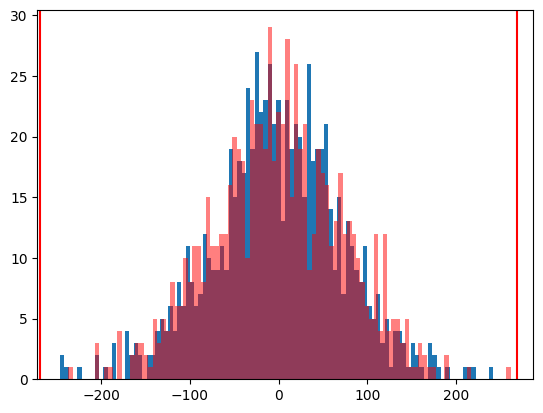

In [85]:
sigma_hat = estimate_Sigma_L(DY.reshape(1, -1), Q)
plt.hist(DY / np.sqrt(np.diff(Q)), bins=100)
np.random.seed(123)
plt.hist(scipy.stats.norm(loc=0, scale=np.sqrt(sigma_hat)).rvs(len(Q)), color='red', alpha=0.5, bins=100)
plt.axvline(np.sqrt(2.02*sigma_hat*np.log(len(Q))), color='red')
plt.axvline(-np.sqrt(2.02*sigma_hat*np.log(len(Q))), color='red')
plt.show()

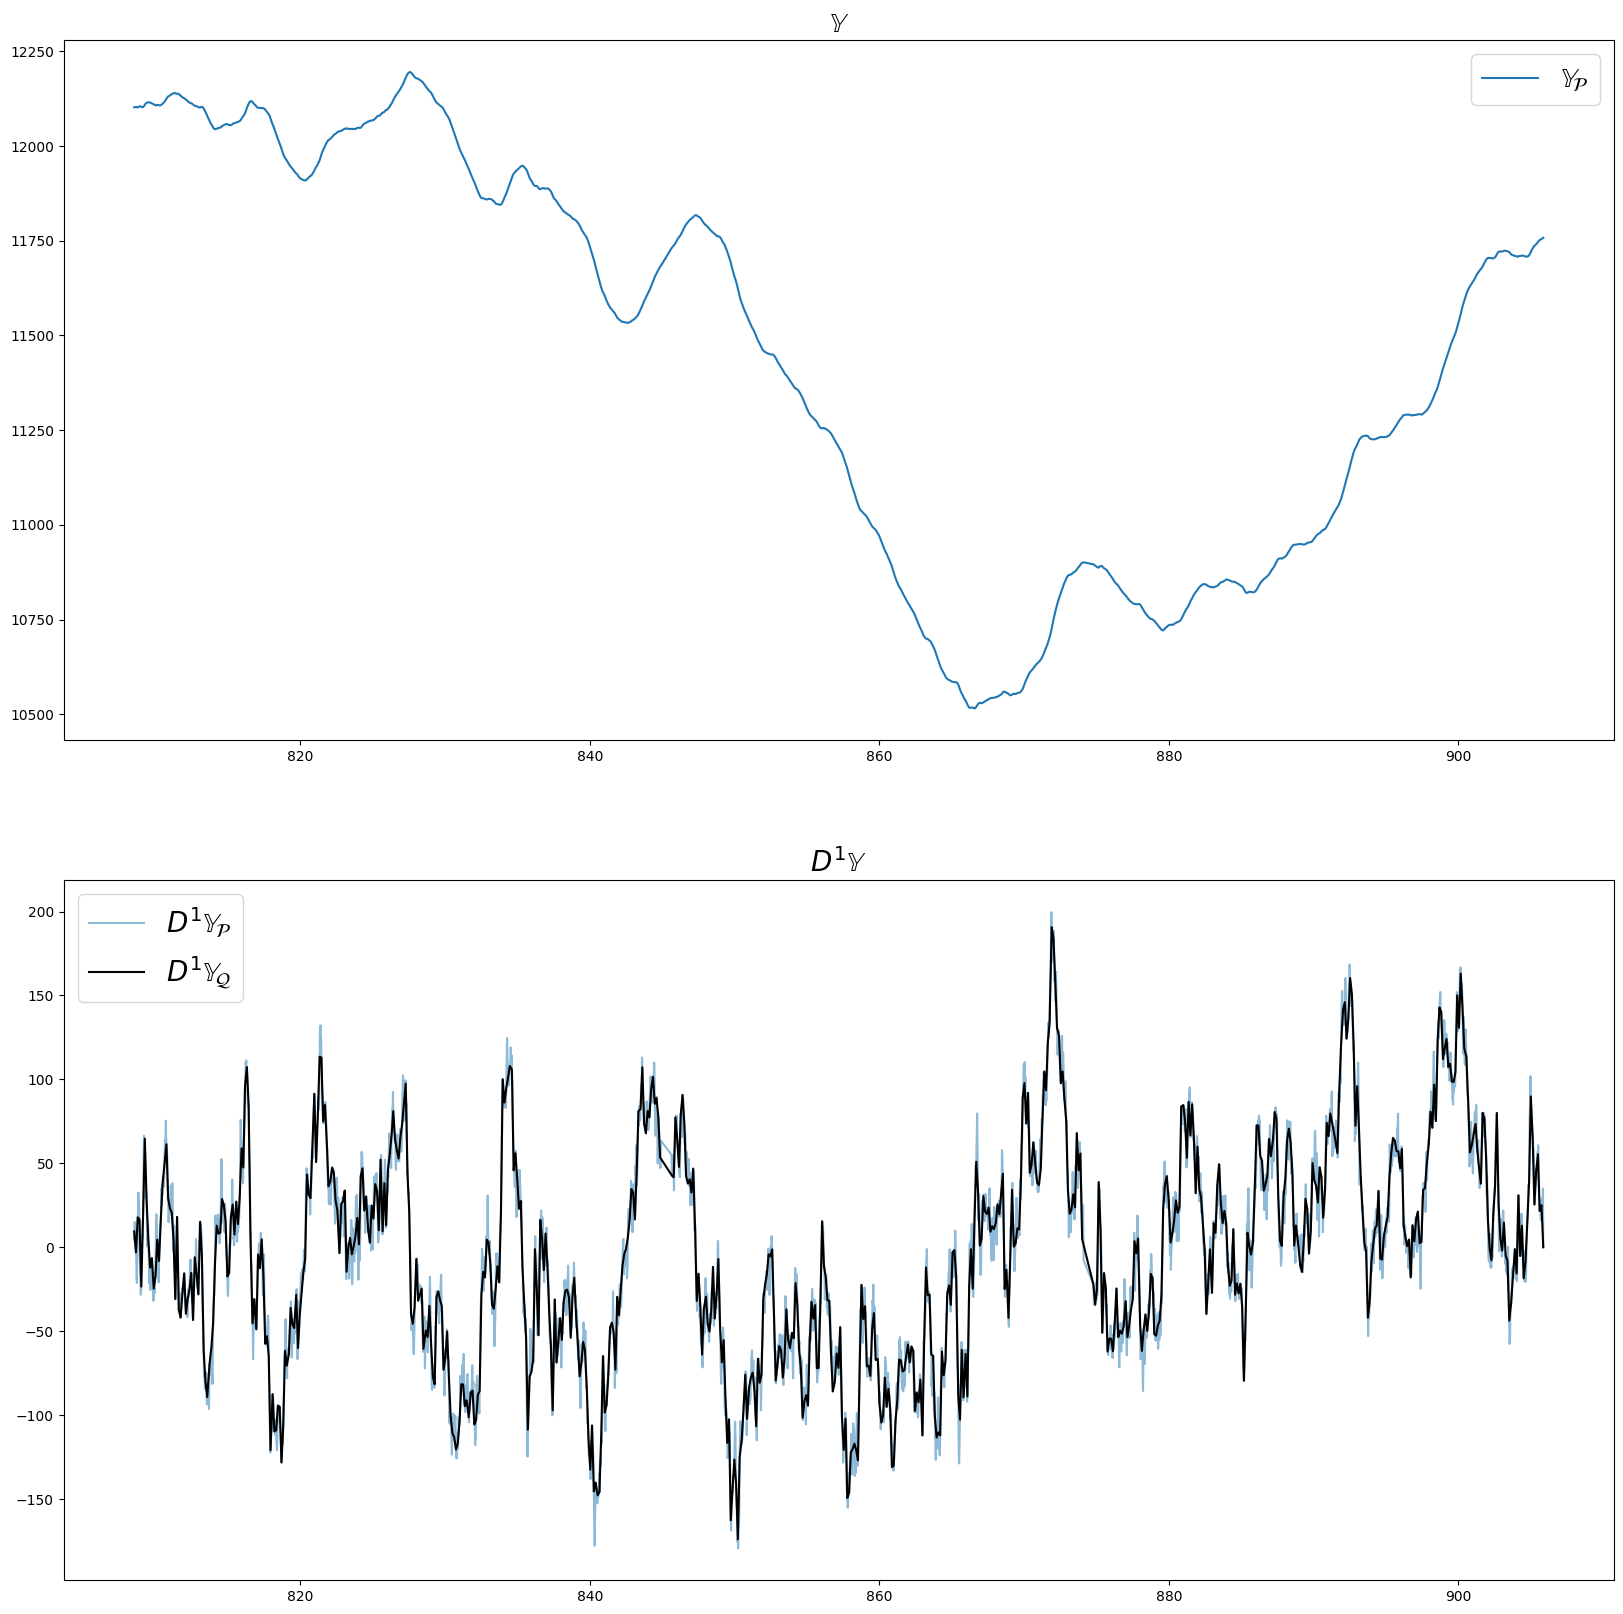

In [ ]:
d = 1

# MCAR parameters
AA = AA_hat

# build state space autoregressive matrix
A_AA = MCAR_A(AA)

# parameters of Levy process (we assume it has finite Levy measure)
b = b_hat * np.ones(d)
Sigma = Sigma_hat * np.eye(d)
if jump_scale > 0:
    raise NotImplementedError('Explicitly model the jump-component of the Levy process if jumps are detected.')
    # jumps = partial(gamma_increments, shape=jump_rate, scale=jump_scale, d=d) # here might need to redefine beta
    # jumps = scipy.stats.multivariate_normal(mean=np.zeros(d), cov=jump_scale**2*np.eye(d))
else:
    jump_rate = 0
    jumps = None

np.random.seed(123)
x0 = np.zeros(p)
x0[0] = observation[0,0]
if isinstance(jumps, scipy.stats._multivariate.multivariate_normal_frozen) or isinstance(jumps, None):
    MCAR_X, jump_times, jump_sizes = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, jump_rate, jumps, uniform=False, output_format='SS + jumps')
    MCAR = MCAR_X[:d, :]
else:
    MCAR = simulate_MCAR_approx(P, A_AA, x0, b, Sigma, jumps, uniform=False)

S = state_space(MCAR, p, P)
S_Q = S[:, indices]

fig, axes = plt.subplots(p, 1, figsize=(20, p*10))
if p == 1:
    axes = [axes]
for j in range(p):
    axes[j].plot(P, S[j, :], label=f'$D^{{{j}}}\mathbb{{Y}}_{{\mathcal{{P}}}}$' if j > 0 else '$\mathbb{Y}_{\mathcal{P}}$', alpha = 1 if j == 0 else 0.5)
    axes[j].set_title(f'$D^{{{j}}}\mathbb{{Y}}$' if j > 0 else '$\mathbb{Y}$', fontsize=20)
    if j > 0:
        axes[j].plot(Q, S_Q[j, :], label=f'$D^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$', color='black')
    if j == p - 1:
        for i, jump_time in enumerate(jump_times):
            jump_index = np.argmax(jump_time < Q) - 1
            axes[j].plot(Q[jump_index:jump_index+2], S_Q[j, jump_index:jump_index+2], color='red', label=f'$D^{{{j}}}\mathbb{{Y}}_{{\mathcal{{Q}}}}$ jumps' if i==0 else '')
    axes[j].legend(fontsize=20)

## Spectral analysis

### Periodogram

In [ ]:
def CAR_spectrum(AA: list[np.ndarray], Sigma_L: float, freqs: np.ndarray, one_sided: bool = True):
    """
    Assume process is one-dimensional.
    """
    p = len(AA)
    x = (2 * np.pi * 1j * freqs)**p
    for k, A_k in enumerate(AA):
        x += A_k[0, 0] * (2 * np.pi * 1j * freqs)**(p-1-k)
    psd = Sigma_L / np.abs(x)**2
    if one_sided:
        return 2 * psd[freqs > 0]
    else:
        return psd

In [94]:
psd_estimator_name = 'periodogram'
if psd_estimator_name == 'welch':
    psd_estimator = scipy.signal.welch
elif psd_estimator_name == 'periodogram':
    psd_estimator = scipy.signal.periodogram

freqs, psd_data = psd_estimator(Y.flatten(), fs = (len(P) - 1) / P.ptp(), scaling='density')
freqs_noise, psd_noise = psd_estimator(raw_data - smoothed_data, fs = (len(P) - 1) / P.ptp(), scaling='density')

DeltaL_hat = recover_BDLP(Y, p, P, Q, AA_hat)
Sigma_L_hat = estimate_Sigma(DeltaL_hat - b_hat*np.diff(Q), np.diff(Q))
freqs_CAR = np.linspace(freqs[0], freqs[-1], 1000)
CAR_estimated_periodogram = CAR_spectrum(AA_hat, Sigma_L_hat.item(), freqs_CAR)

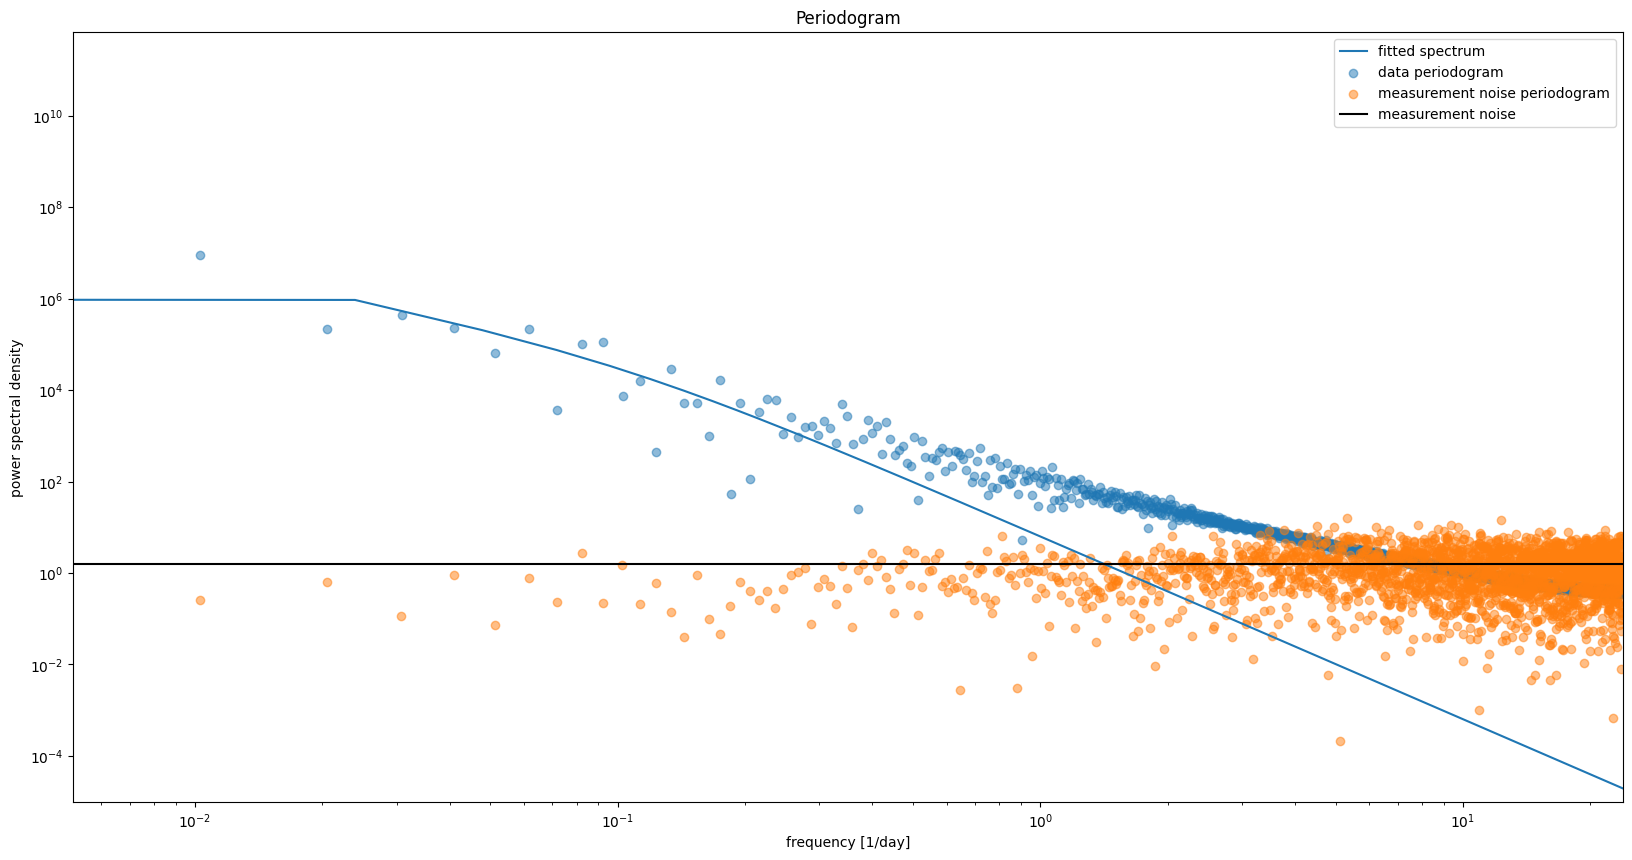

In [101]:
# standard periodogram (assumes evenly spaced data)
plt.figure(figsize=(20, 10))
plt.plot(freqs_CAR, CAR_estimated_periodogram, label='fitted spectrum')
plt.scatter(freqs, psd_data, label=f'data {psd_estimator_name}', alpha=0.5)
plt.scatter(freqs_noise, psd_noise, label=f'measurement noise {psd_estimator_name}', alpha=0.5)
plt.axhline(((raw_data - smoothed_data)**2).mean() / freqs.ptp(), label='measurement noise', color='black')
plt.xscale('log')
plt.title('Periodogram')
plt.xlabel('frequency [1/day]')
plt.ylabel('power spectral density')
plt.yscale('log')
plt.xlim([freqs[1]/2, freqs[-1]])
plt.ylim([min(CAR_estimated_periodogram)/2, 10*max(CAR_estimated_periodogram)])
plt.legend()
plt.show()

Properties of the spectogram on P (not really designed for unevenly spaced partition but if it's not too bad, i.e. all timesteps are roughly 1/T then ok). Can empirically check this is indeed a sensible procedure by simulating multiple realizations from a CAR(p) process over P and checking that it roughly estimates the theoretical psd. Moreover note that the data psd looks like the typical psd of a realization of the CAR processes with the fitted parameters.

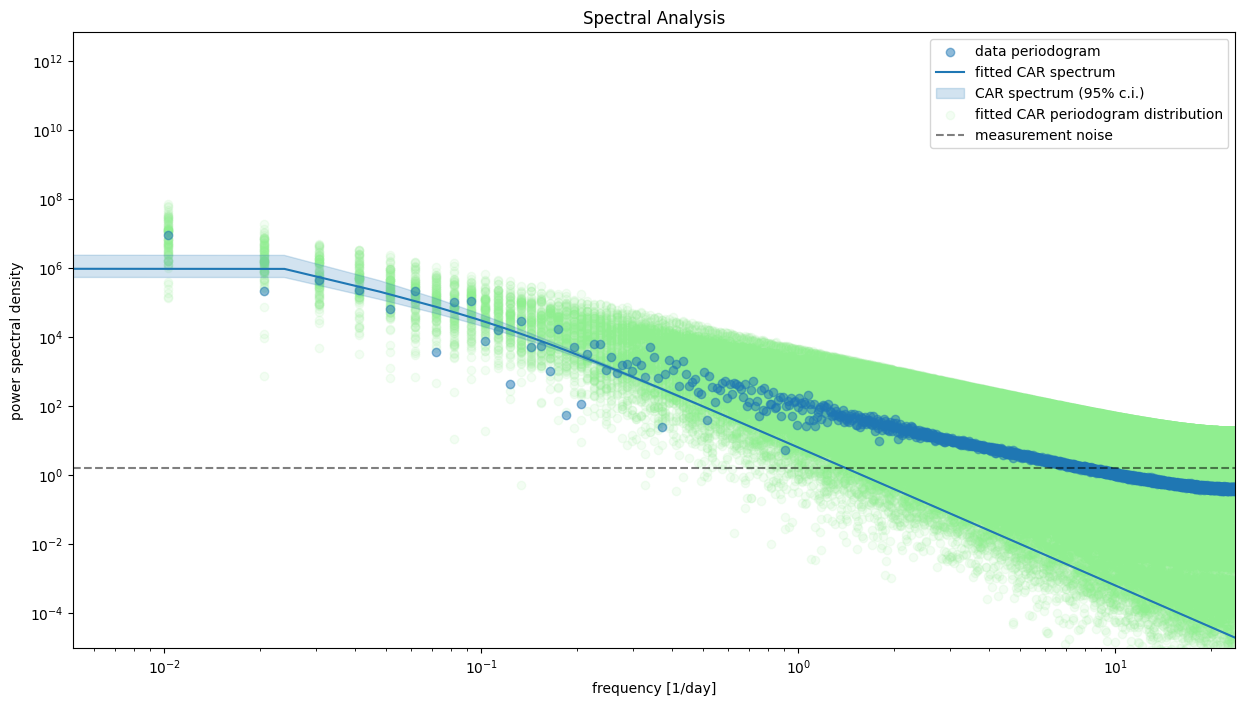

In [99]:
tot = 100
fast = True

fig = plt.figure(figsize=(15, 8))
freqs_all = np.array([])
periodogram_sim_all = np.array([])
for _ in range(tot):
    if jump_rate > 0:
        raise NotImplementedError('Explicitly model the jump-component of the Levy process if jumps are detected.')
    else:
        if fast and not isinstance(jumps, scipy.stats._multivariate.multi_rv_frozen):
            MCAR = simulate_MCAR_approx(P, A_AA, x0, b, Sigma, jumps, uniform=False)
        else:
            MCAR = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, rate=0, jump_F=None, uniform=False)
    freqs, periodogram_sim = psd_estimator(MCAR.flatten(), fs = len(P) / P.ptp(), scaling='density')
    freqs_all = np.concatenate([freqs_all, freqs])
    periodogram_sim_all = np.concatenate([periodogram_sim_all, periodogram_sim])
plt.scatter(
    freqs_all, 
    periodogram_sim_all, 
    label=f'fitted CAR {psd_estimator_name} distribution', 
    color='lightgreen', 
    alpha=0.1
)
plt.scatter(
    freqs, 
    psd_data, 
    label=f'data {psd_estimator_name}', 
    alpha=0.5
)
plt.plot(
    freqs_CAR, 
    CAR_estimated_periodogram, 
    label='fitted CAR spectrum'
)
CAR_estimated_periodograms = []
for _ in range(tot):
    AA_hat_sample = inv_vectorize_AA(np.random.multivariate_normal(vectorize_AA(AA_hat), AA_hat_cov), p)
    CAR_estimated_periodograms.append(CAR_spectrum(AA_hat_sample, Sigma_L_hat.item(), freqs_CAR))
CAR_estimated_periodograms = np.stack(CAR_estimated_periodograms, axis=0)
plt.fill_between(
    freqs_CAR, 
    np.sort(CAR_estimated_periodograms, axis=0)[int(tot*0.025)], 
    np.sort(CAR_estimated_periodograms, axis=0)[int(tot*0.975)], 
    alpha = 0.2, 
    color = 'tab:blue', 
    label=r'CAR spectrum (95% c.i.)'
)
plt.xlim([freqs[1]/2, freqs[-1]])
plt.ylim([min(CAR_estimated_periodogram)/2, 100*max(CAR_estimated_periodogram)])
plt.axhline(
    ((raw_data - smoothed_data)**2).mean() / (max(freqs)), 
    label = 'measurement noise', 
    color = 'black', 
    linestyle = '--', 
    alpha = 0.5
)
plt.xscale('log')
plt.title('Spectral Analysis')
plt.xlabel('frequency [1/day]')
plt.ylabel('power spectral density')
plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 0, 4]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.show()
fig.savefig(os.path.join(plots_dir, f'spectral_analysis_{psd_estimator_name}.png'))

### Lomb-Scargle Periodogram

Note that the observation partition P is not perfectly regular:

In [173]:
from collections import Counter

Counter(np.round(np.diff(P), 5))

Counter({0.02043: 4601, 0.04087: 46, 0.0613: 1, 0.71521: 1, 0.67434: 1})

We thus consider the Lomb Scargle estimator of the PSD.

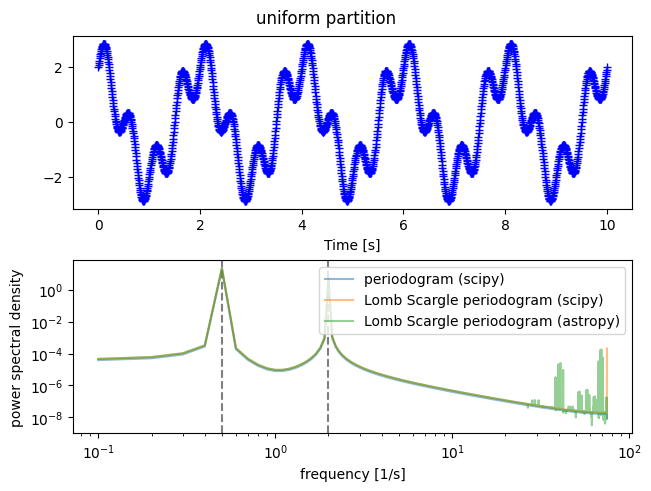

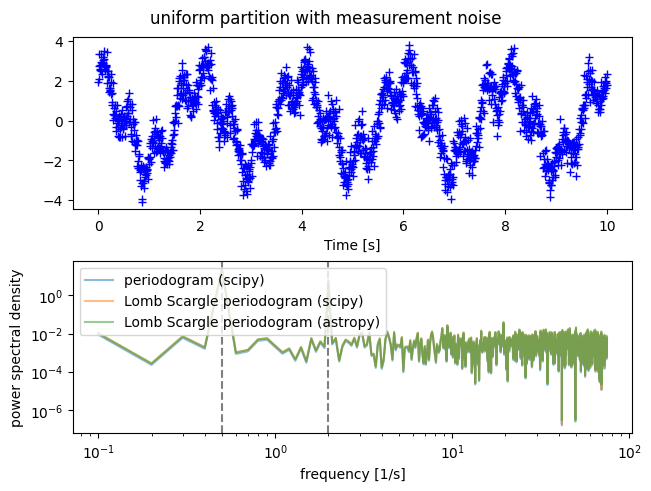

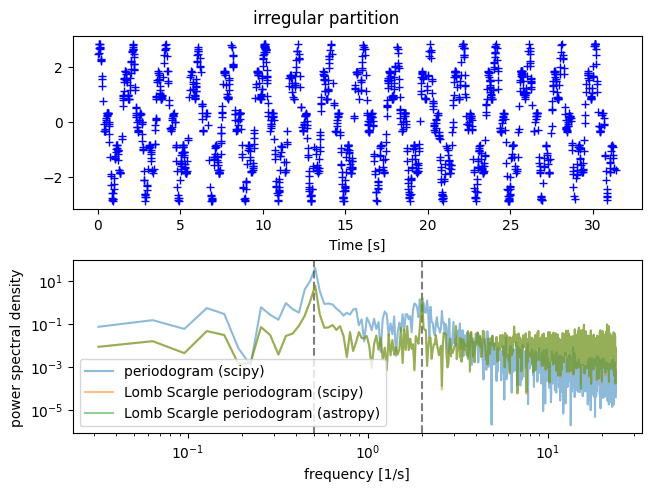

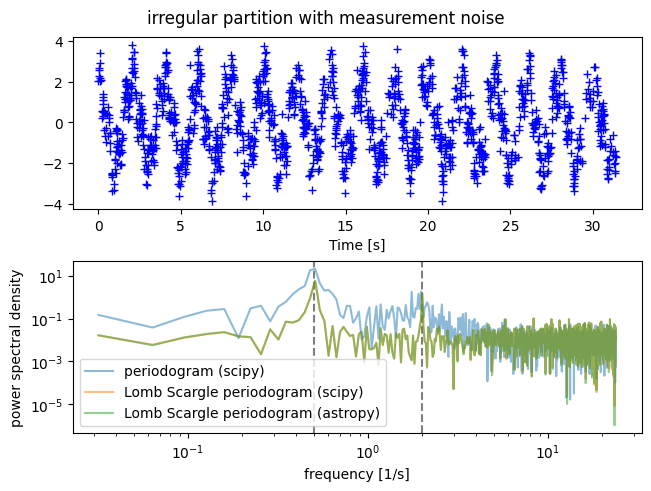

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from astropy.timeseries import LombScargle
rng = np.random.default_rng()

A0 = 2.
A1 = 1
f0 = 0.5
f1 = 2
nin = 1500
nout = 100000

for partition in ['uniform', 'irregular']:
    for measurement_noise in [False, True]:
        if partition == 'uniform':
            x = np.linspace(0, 10, nin)
        elif partition == 'irregular':
            x = np.sort(rng.uniform(0, 10*np.pi, nin))        

        y = A0 * np.cos(2*np.pi*f0*x) + A1 * np.sin(2*np.pi*f1*x) + rng.normal(0, 0.5, nin) * measurement_noise

        fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
        ax_t.plot(x, y, 'b+')
        ax_t.set_xlabel('Time [s]')

        fs = (len(x) - 1) / x.ptp()

        f, Pxx_periodogram = scipy.signal.periodogram(y, fs)
        f, Pxx_periodogram = f[1:], Pxx_periodogram[1:]
        # need to re-normalize to get a power spectral density in Hz
        Pxx_ls_scipy = scipy.signal.lombscargle(x, y, f * 2 * np.pi) / (len(x) * 2 * np.pi) * fs
        Pxx_ls_astropy = LombScargle(x, y).power(f, normalization='psd') / (len(x) * 2 * np.pi) * fs

        ax_w.axvline(f0, color='k', linestyle='--', alpha=0.5)
        ax_w.axvline(f1, color='k', linestyle='--', alpha=0.5)
        ax_w.plot(f, Pxx_periodogram, label = 'periodogram (scipy)', alpha=0.5)
        ax_w.plot(f, Pxx_ls_scipy, label = 'Lomb Scargle periodogram (scipy)', alpha=0.5)
        ax_w.plot(f, Pxx_ls_astropy, label = 'Lomb Scargle periodogram (astropy)', alpha=0.5)
        ax_w.set_xlabel('frequency [1/s]')
        ax_w.set_ylabel('power spectral density')
        ax_w.legend()
        ax_w.set_yscale('log')
        ax_w.set_xscale('log')
        fig.suptitle(f'{partition} partition' + ' with measurement noise'*measurement_noise)
        plt.show()

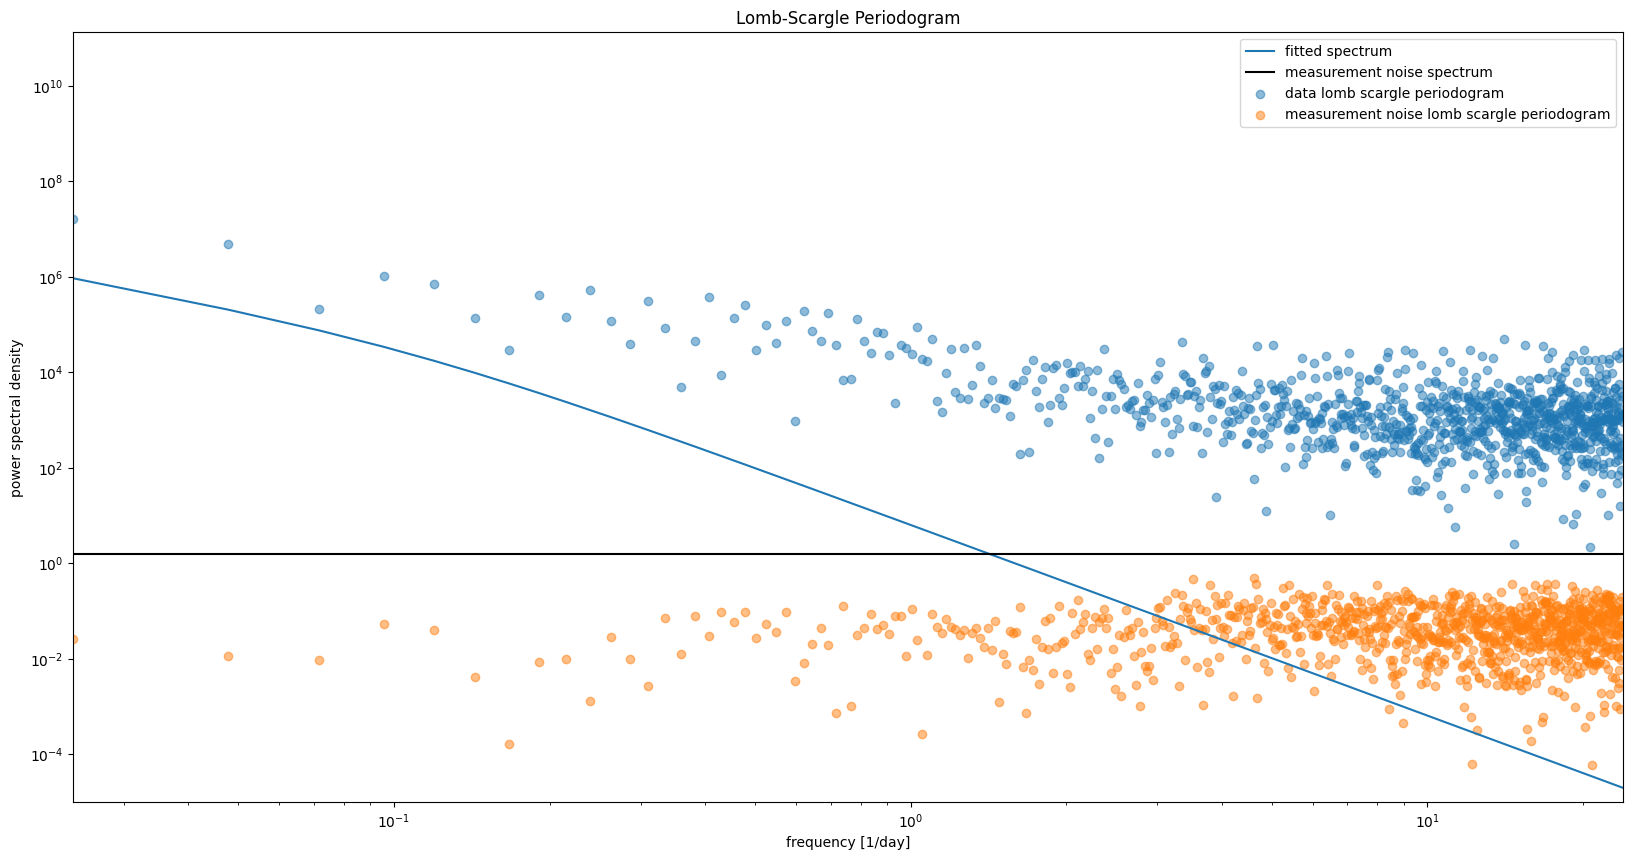

In [181]:
# "empirical" periodogram for unevenly spaced data
def lombscargle_psd_estimator(t, y, freqs):
    fs = (len(t) - 1) / t.ptp()
    return freqs, scipy.signal.lombscargle(t, y, (2 * np.pi) * freqs) / (len(t) * 2 * np.pi) * fs

plt.figure(figsize=(20, 10))

CAR_estimated_periodogram = CAR_spectrum(AA_hat, Sigma_L_hat.item(), freqs_CAR)
freqs = freqs_CAR[freqs_CAR > 0]

plt.plot(freqs_CAR, CAR_estimated_periodogram, label='fitted spectrum')
plt.axhline(((raw_data - smoothed_data)**2).mean() / freqs.ptp(), label='measurement noise spectrum', color='black')
plt.scatter(freqs, lombscargle_psd_estimator(P, Y.flatten(), freqs)[1], label='data lomb scargle periodogram', alpha=0.5)
plt.scatter(freqs, lombscargle_psd_estimator(time_grid, raw_data - smoothed_data, freqs)[1], label='measurement noise lomb scargle periodogram', alpha=0.5)
plt.title('Lomb-Scargle Periodogram')
plt.xscale('log')
plt.xlabel('frequency [1/day]')
plt.ylabel('power spectral density')
plt.yscale('log')
plt.xlim([freqs[1]/2, freqs[-1]])
plt.ylim([min(CAR_estimated_periodogram)/2, 2*max(CAR_estimated_periodogram)])
plt.legend()
plt.show()

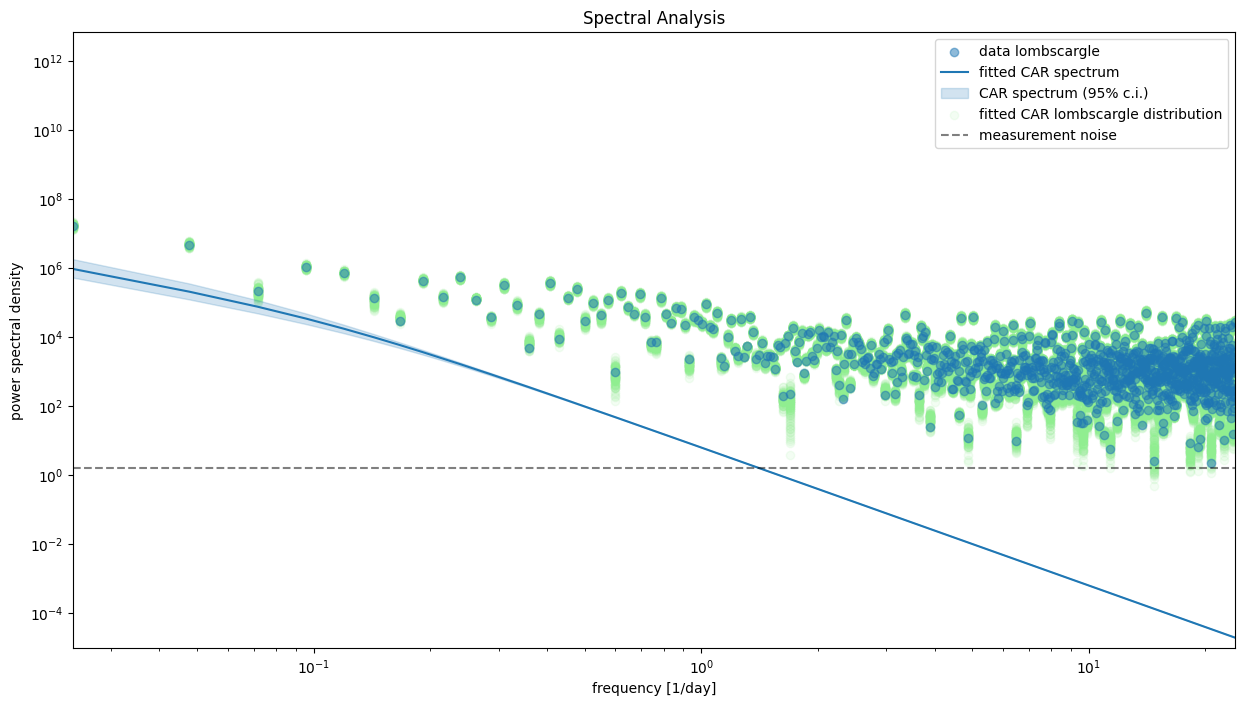

In [184]:
psd_estimator_name = 'lombscargle'
tot = 100
fast = True

fig = plt.figure(figsize=(15, 8))
freqs_all = np.array([])
periodogram_sim_all = np.array([])
for _ in range(tot):
    if jump_rate > 0:
        raise NotImplementedError('Explicitly model the jump-component of the Levy process if jumps are detected.')
    else:
        if fast and not isinstance(jumps, scipy.stats._multivariate.multi_rv_frozen):
            MCAR = simulate_MCAR_approx(P, A_AA, x0, b, Sigma, jumps, uniform=False)
        else:
            MCAR = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, rate=0, jump_F=None, uniform=False)
    periodogram_sim = lombscargle_psd_estimator(P, MCAR.flatten(), freqs)[1]
    freqs_all = np.concatenate([freqs_all, freqs])
    periodogram_sim_all = np.concatenate([periodogram_sim_all, periodogram_sim])
plt.scatter(
    freqs_all, 
    periodogram_sim_all, 
    label=f'fitted CAR {psd_estimator_name} distribution', 
    color='lightgreen', 
    alpha=0.1
)
plt.scatter(
    freqs, 
    lombscargle_psd_estimator(P, Y.flatten(), freqs)[1], 
    label=f'data {psd_estimator_name}', 
    alpha=0.5
)
plt.plot(
    freqs_CAR, 
    CAR_estimated_periodogram, 
    label='fitted CAR spectrum'
)
CAR_estimated_periodograms = []
for _ in range(tot):
    AA_hat_sample = inv_vectorize_AA(np.random.multivariate_normal(vectorize_AA(AA_hat), AA_hat_cov), p)
    CAR_estimated_periodograms.append(CAR_spectrum(AA_hat_sample, Sigma_L_hat.item(), freqs_CAR))
CAR_estimated_periodograms = np.stack(CAR_estimated_periodograms, axis=0)
plt.fill_between(
    freqs_CAR, 
    np.sort(CAR_estimated_periodograms, axis=0)[int(tot*0.025)], 
    np.sort(CAR_estimated_periodograms, axis=0)[int(tot*0.975)], 
    alpha = 0.2, 
    color = 'tab:blue', 
    label=r'CAR spectrum (95% c.i.)'
)
plt.xlim([freqs[1]/2, freqs[-1]])
plt.ylim([min(CAR_estimated_periodogram)/2, 100*max(CAR_estimated_periodogram)])
plt.axhline(
    ((raw_data - smoothed_data)**2).mean() / (max(freqs)), 
    label = 'measurement noise', 
    color = 'black', 
    linestyle = '--', 
    alpha = 0.5
)
plt.xscale('log')
plt.title('Spectral Analysis')
plt.xlabel('frequency [1/day]')
plt.ylabel('power spectral density')
plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 0, 4]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.show()
fig.savefig(os.path.join(plots_dir, f'spectral_analysis_{psd_estimator_name}.png'))